## Simulating Radiances

This example covers the simualation of synthetic measurements using pyshdom. This is a simple and streamlined example.

In [1]:
#imports

import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
import os
import importlib

### Make the RTE grid and medium microphysics.

This time we are going to include both cloud and rayleigh scatter. 
The fundamental thing that must be defined first is the `rte_grid`, which sets the domain size. We have an easy choice here from the medium but in the inverse problem this must be selected as the initial step.

In [2]:
cloud_scatterer = at3d.util.load_from_csv('/Users/khargenr/AT3D/at3d/data/synthetic_cloud_fields/jpl_les/rico32x37x26.txt', density='lwc', origin=(0.0,0.0))

#load atmosphere
atmosphere = xr.open_dataset('/Users/khargenr/AT3D/at3d/data/ancillary/AFGL_summer_mid_lat.nc')
#subset the atmosphere, choose only the bottom four km.
reduced_atmosphere = atmosphere.sel({'z': atmosphere.coords['z'].data[atmosphere.coords['z'].data <= 4.0]})
#merge the atmosphere and cloud z coordinates
merged_z_coordinate = at3d.grid.combine_z_coordinates([reduced_atmosphere,cloud_scatterer])

# define the property grid - which is equivalent to the base RTE grid
rte_grid = at3d.grid.make_grid(cloud_scatterer.x.diff('x')[0],cloud_scatterer.x.data.size,
                          cloud_scatterer.y.diff('y')[0],cloud_scatterer.y.data.size,
                          np.append(0,cloud_scatterer.z.data))


In [3]:
#finish defining microphysics because we can.

cloud_scatterer_on_rte_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer)

#We choose a gamma size distribution and therefore need to define a 'veff' variable.
size_distribution_function = at3d.size_distribution.gamma

cloud_scatterer_on_rte_grid['veff'] = (cloud_scatterer_on_rte_grid.reff.dims,
                                       np.full_like(cloud_scatterer_on_rte_grid.reff.data, fill_value=0.1))

### Define Sensors

This is based on AirMSPI - like measurements. 9 observations in an arc.

Two perspective cameras either ground-based or out of an aircraft window.

and eMAS observations - nadir multi-spectral measurements.

By default, the resolution arguments for the sensors are actually spacing between rays. The radiance calculation itself is still just a single idealized ray. To more accurately model a wide pixel field of view we can model several sub-pixel-rays in each pixel.

In [4]:
sensor_dict = at3d.containers.SensorsDict()

In [5]:
sensor_zenith_list = [75.0,67.5,60.0,52,45.6,35,26.1,10.0]*2 + [0.0]
sensor_azimuth_list = [90]*8 + [-90]*8 +[0.0]
for zenith,azimuth in zip(sensor_zenith_list,sensor_azimuth_list):
    sensor_dict.add_sensor('MSPI', 
            at3d.sensor.orthographic_projection(0.86, cloud_scatterer,0.02,0.02, azimuth, zenith,
                                     altitude='TOA', stokes='I')
                          )

In [6]:
# add some perspective cameras
sensor_dict.add_sensor('SideViewCamera', 
        at3d.sensor.perspective_projection(0.86, 20.0,100,100,[5.0, 0.32, 1.0],[0.01,0.32,1.0],[0,0,1],
                                 stokes='I')
                      )

sensor_dict.add_sensor('GroundCamera', 
        at3d.sensor.perspective_projection(0.86, 80.0,120,120,[0.32, 0.32, 0.001],[0.32,0.32,1.0],[0,1,0],
                                 stokes='I')
                      )

In [7]:
for wavelength in [1.65, 2.2, 3.7]:
    sensor_dict.add_sensor('eMAS', 
            at3d.sensor.orthographic_projection(wavelength, cloud_scatterer,0.02,0.02, azimuth, zenith,
                                     altitude='TOA', stokes='I',
                                                  )
                          )

Here we make a sensor that now integrates over the radiance field in each pixel's field of view using gauss-legendre quadrature.

In [8]:
for wavelength in [1.65]:
    sensor_dict.add_sensor('eMAS_SubPixel', 
            at3d.sensor.orthographic_projection(wavelength, cloud_scatterer,0.02,0.02, azimuth, zenith,
                                     altitude='TOA', stokes='I',
                                    sub_pixel_ray_args={
                                        'method':at3d.sensor.gaussian,
                                        'degree':3
                                    })
                          )

In [9]:
wavelengths = sensor_dict.get_unique_solvers()

### get optical property generators

Note that we assume a monochromatic model here.

In [10]:
mie_mono_tables = OrderedDict()
for wavelength in wavelengths:
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )

In [11]:
optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    size_distribution_function,
    reff=np.linspace(5.0,30.0,30),
    veff=np.linspace(0.03,0.2,9),
)
optical_properties = optical_property_generator(cloud_scatterer_on_rte_grid)

In [12]:
# one function to generate rayleigh scattering.
rayleigh_scattering = at3d.rayleigh.to_grid(wavelengths,atmosphere,rte_grid)

## Define Solvers

Define solvers last based on the sensor's spectral information.

In [13]:
# NB IF YOU REDEFINE THE SENSORS BUT KEEP THE SAME SET OF SOLVERS 
# THERE IS NO NEED TO REDEFINE THE SOLVERS YOU CAN SIMPLY RERUN
# THE CELL BELOW WITHOUT NEEDING TO RERUN THE RTE SOLUTION.

solvers_dict = at3d.containers.SolversDict()
# note we could set solver dependent surfaces / sources / numerical_config here
# just as we have got solver dependent optical properties.

for wavelength in sensor_dict.get_unique_solvers():
    medium = {
        'cloud': optical_properties[wavelength],
        'rayleigh':rayleigh_scattering[wavelength]
     }
    config = at3d.configuration.get_config()
    solvers_dict.add_solver(
        wavelength,
        at3d.solver.RTE(
            numerical_params=config,
            surface=at3d.surface.lambertian(0.0),
            source=at3d.source.solar(wavelength, 0.5,0.0),
            medium=medium,
            num_stokes=1#sensor_dict.get_minimum_stokes()[wavelength],
        )                   
   )

In [14]:
%%time
# solve the 4 RTEs in parallel AND get the measurements.
sensor_dict.get_measurements(solvers_dict, n_jobs=4, verbose=True)

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.650 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.200 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.860 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 3.700 micron]
     1  -0.713  0.355E+00    31968    39.47  0.154   [Radiance 1.650 micron]
     1  -0.745  0.254E+00    31968    39.47  0.154   [Radiance 3.700 micron]
     1  -0.724  0.378E+00    31968    39.47  0.154   [Radiance 0.860 micron]
     1  -0.668  0.325E+00    31968    39.47  0.154   [Radiance 2.200 micron]
     2  -1.210  0.402E+00    31968    39.47  0.154   [Radiance 1.650 micron]
     2  -1.205  0.284E+00    31968    39.47  0.154   [Radiance 3.700 micron]
     2  -1.329  0.417E+00    31968    39.47  0.154   [Radiance 0.860 micron]
     2  -1.073  0.375E+00    31968    39.47  0.154   [Radiance 2.200 micron]
     3  -1.545  0.422E+00    31968    39.47  0.154   [Radiance 1.650 micron]
     3  -1.

### Visualize the observations


In [15]:
# The side view camera has some rays very close to horizontal.
# Because of the Cartesian geometry and flat surface these rays pass through a much 
# longer optical path of rayleigh scatter than nearby rays creating a strong
# line of apparent radiance.

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_16529/957028329.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  py.figure()


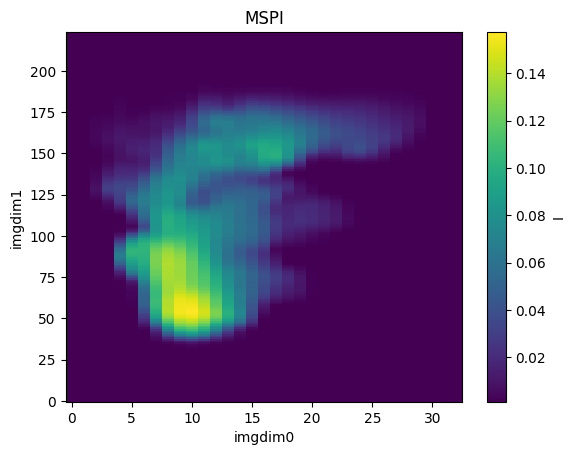

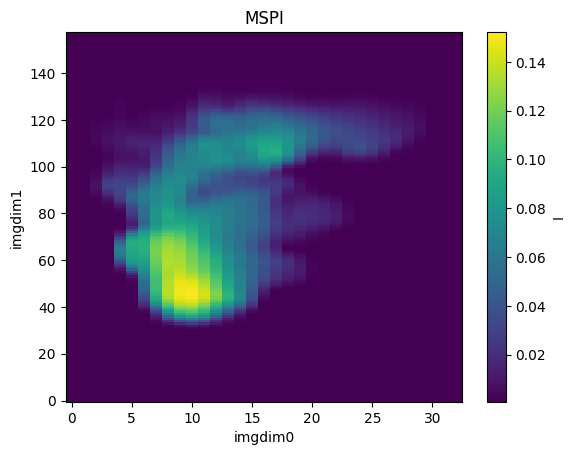

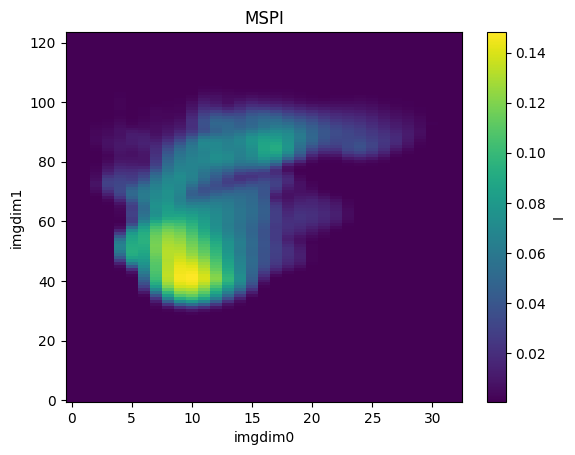

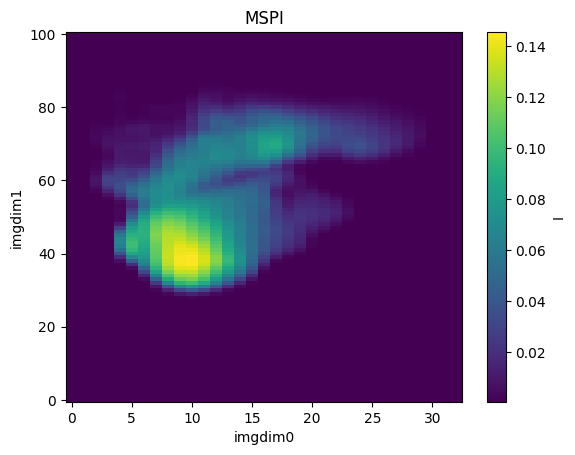

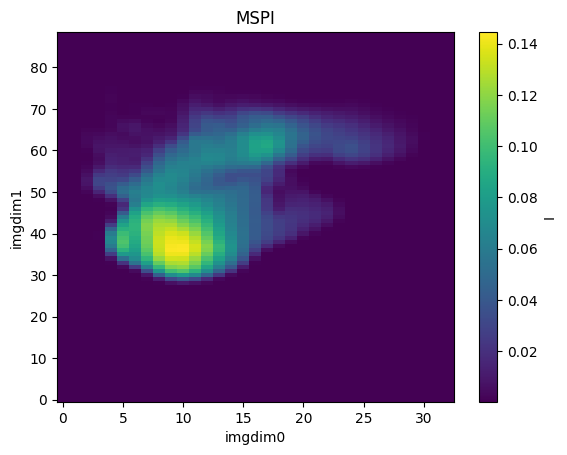

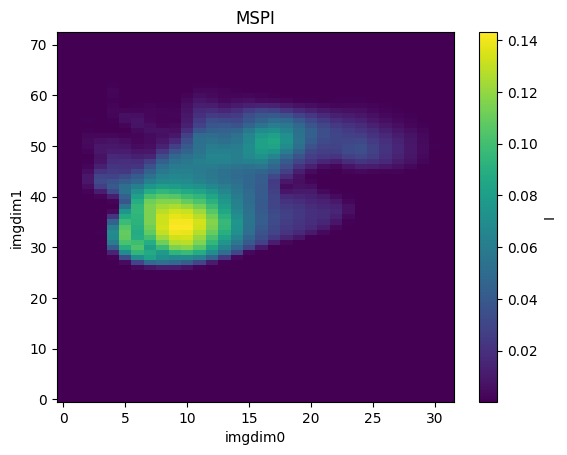

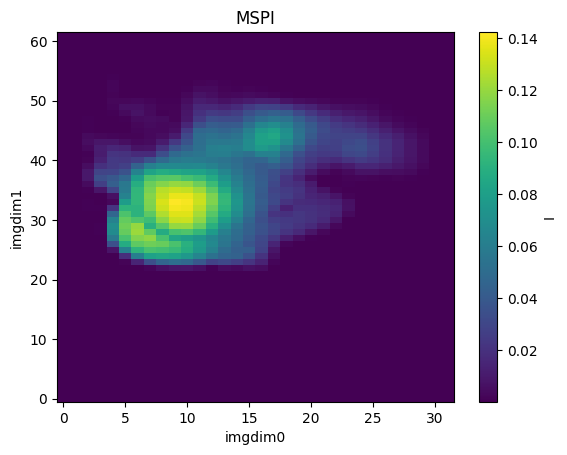

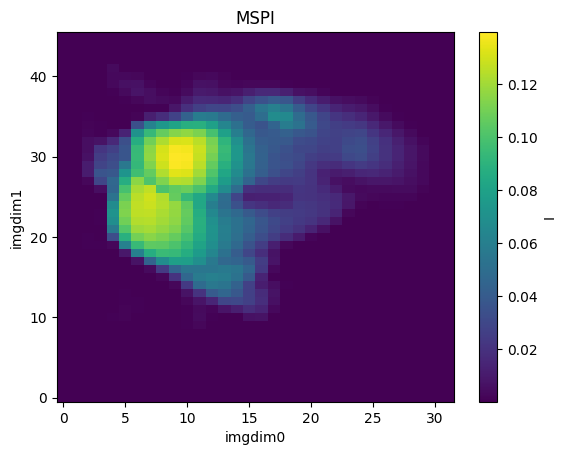

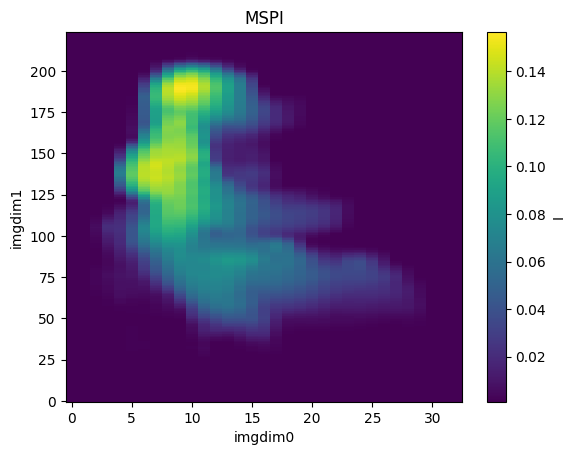

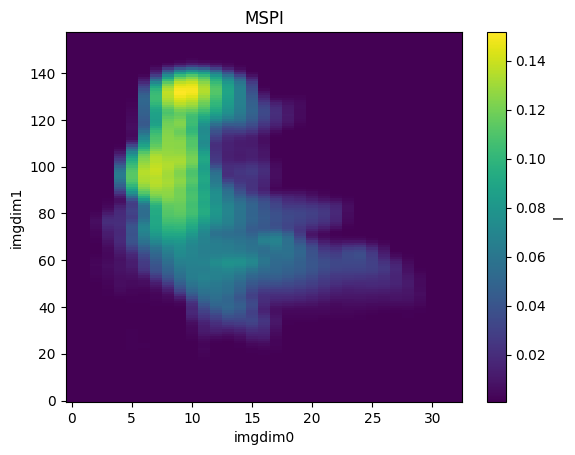

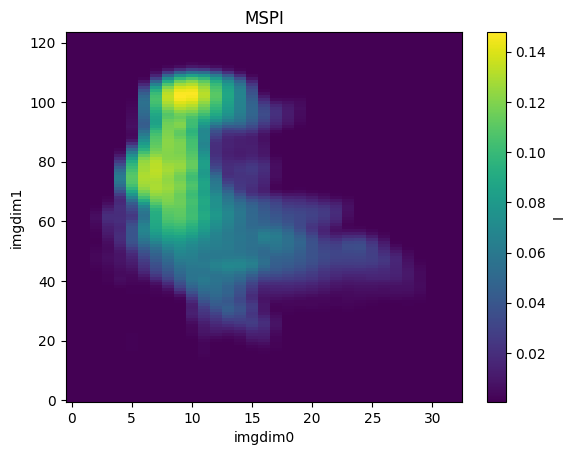

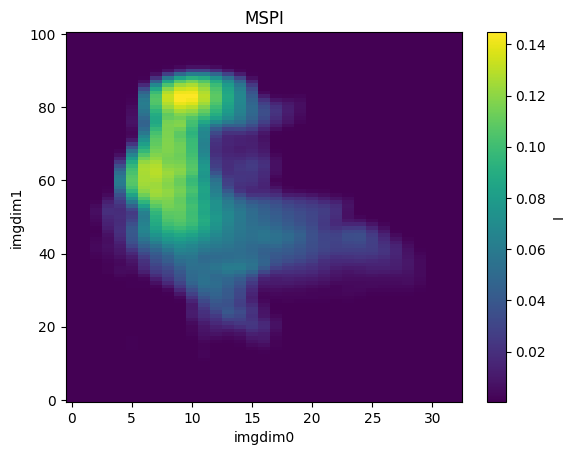

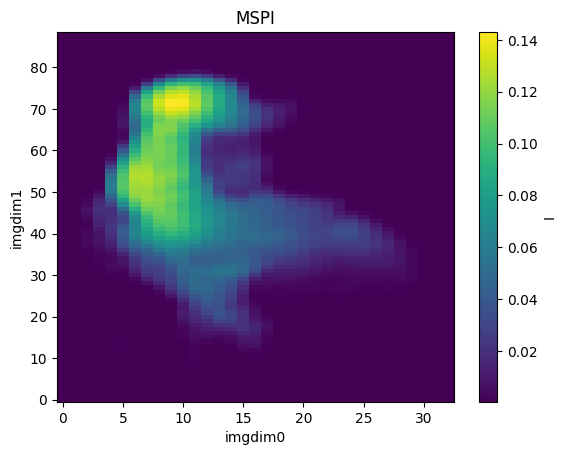

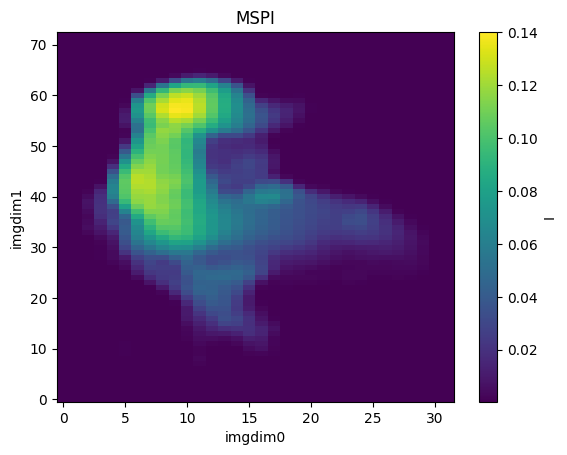

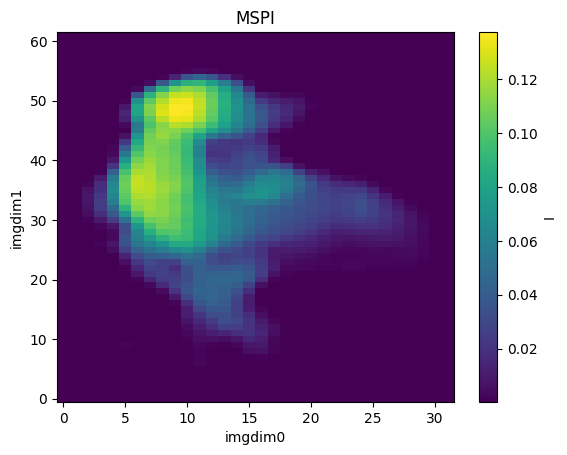

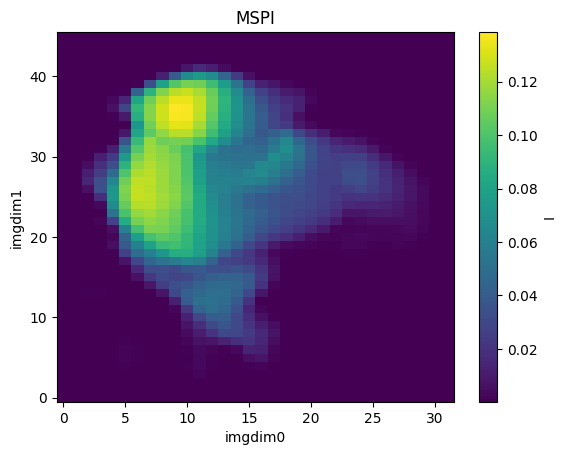

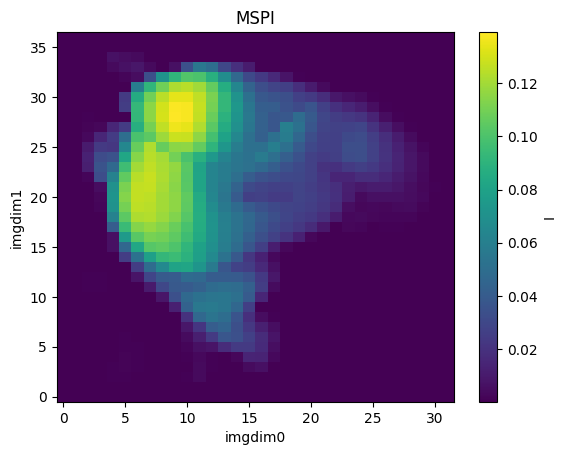

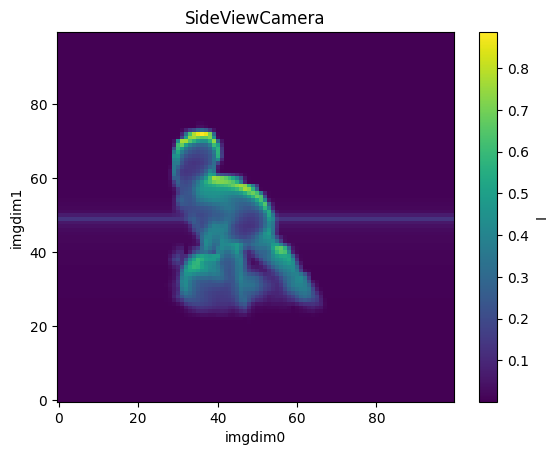

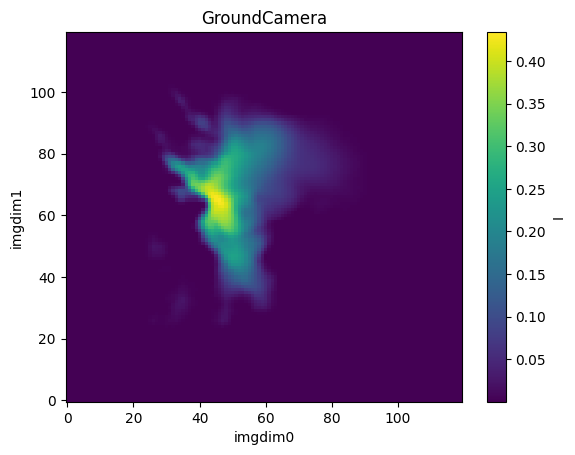

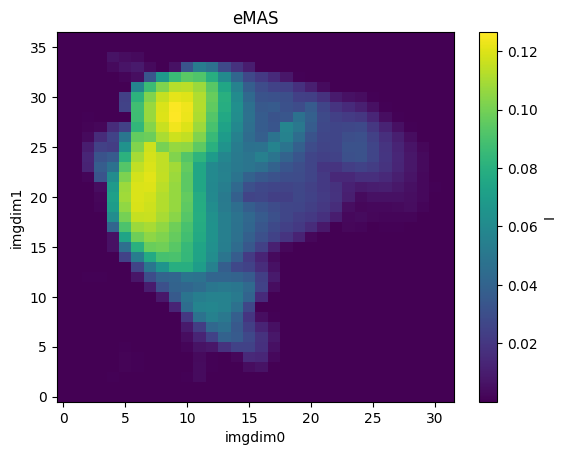

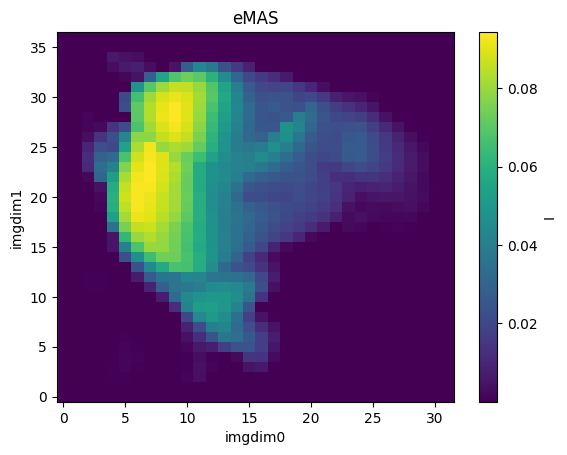

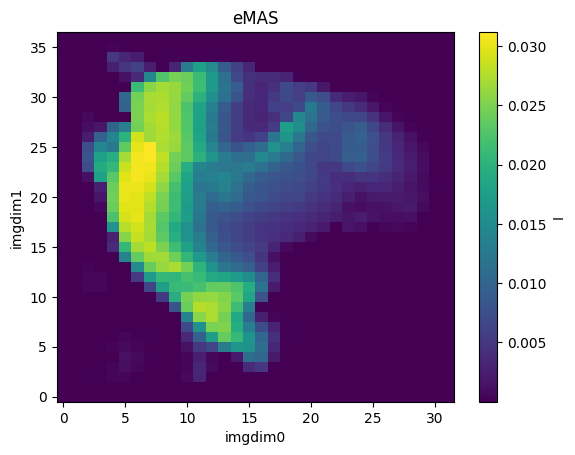

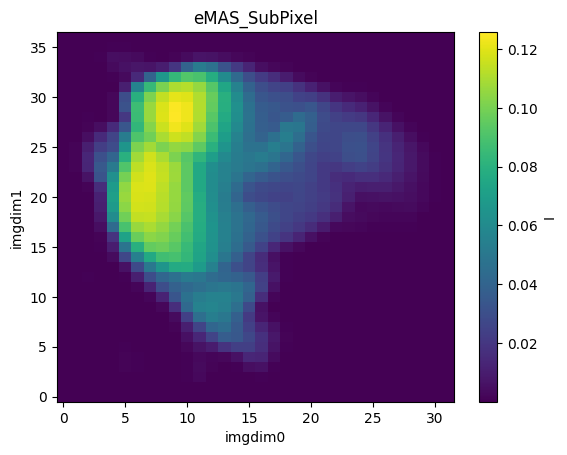

In [16]:
for instrument in sensor_dict:
    sensor_images = sensor_dict.get_images(instrument)
    for sensor in sensor_images:
        py.figure()
        sensor.I.T.plot()
        py.title(instrument)

In [17]:
# Save the model. This saves the inputs required to form the solver object
# and also the sensor_data. The radiative transfer solutions themselves are not saved by default
# as they are large.
# See solver.save_solution / solver.load_solution() for how to save & load those RTE solutions.
# Those functions are not yet integrated into util.save_forward_model / util.load_forward_model.
at3d.util.save_forward_model('SimulateRadiances.nc', sensor_dict, solvers_dict)